In [1]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.resume import load_pretrained_model
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [2]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_" \
# "bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs32_ep50_lr1e-04_ds1000-g1.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")

# from experiments.exp_mamaba_vit_stack.models.hybrid_mamba_vit import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs64_ep1_lr1e-04_ds1008_g500_sched-RLRP.yml")

from models.model_vit import create_model
cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
"experiments/exp_adding_loss_weights_for_q0_emphasis/config/" \
"vit_tiny_patch16_224_gaussian_bs32_ep200_lr1e-04_p60_ds1008_g500_sched-RLRP_preload_p12.yml")



# cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_adding_loss_weights_for_q0_emphasis/config/vit_tiny_patch16_224_gaussian_bs32_ep200_lr1e-04_p60_ds1008_g500_sched-RLRP_preload_p12.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis",
  "backbone": "vit_gaussian",
  "batch_size": 32,
  "epochs": 2,
  "learning_rate": 0.0001,
  "patience": 60,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
  "train_csv": "/home/arsal

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0


In [4]:
device= get_device_summary()

=== NVIDIA-SMI ===
Thu Aug 28 10:03:15 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   32C    P5              24W / 220W |   1348MiB /  8192MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 26
[INFO] Length of validation dataloader: 4
[INFO] Length of test dataloader: 4


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using ViT model: vit_tiny_patch16_224, pretrained: False


ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none

In [7]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [8]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] 🔁 Resuming training from checkpoint and summary
[INFO] Resumed at epoch 2 with total acc 0.6337 from epoch 1 and early stop counter 0


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [13]:
model, preloaded = load_pretrained_model(model, device, cfg)


[INFO] 🔄 Preloading model weights from experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds7200000_g500_sched_ReduceLROnPlateau_preloaded/best_model.pth
[INFO] ✅ Pretrained weights loaded successfully.


In [14]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [15]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

In [16]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/training_summary.json

🏁 Best Model @ Epoch 1
Total Accuracy: 0.6337

🔹 ENERGY Task
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1-Score : 1.0000
  Confusion Matrix:
[[26, 0], [0, 75]]

🔹 ALPHA Task
  Accuracy : 0.8812
  Precision: 0.8965
  Recall   : 0.8801
  F1-Score : 0.8843
  Confusion Matrix:
[[30, 4, 0], [3, 32, 0], [0, 5, 27]]

🔹 Q0 Task
  Accuracy : 0.7426
  Precision: 0.7742
  Recall   : 0.7437
  F1-Score : 0.7415
  Confusion Matrix:
[[26, 0, 0, 0], [0, 19, 5, 0], [0, 2, 19, 4], [0, 1, 14, 11]]


📊 Plots saved to:
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/loss_accuracy_plot.png
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/loss_accuracy_plot.pdf


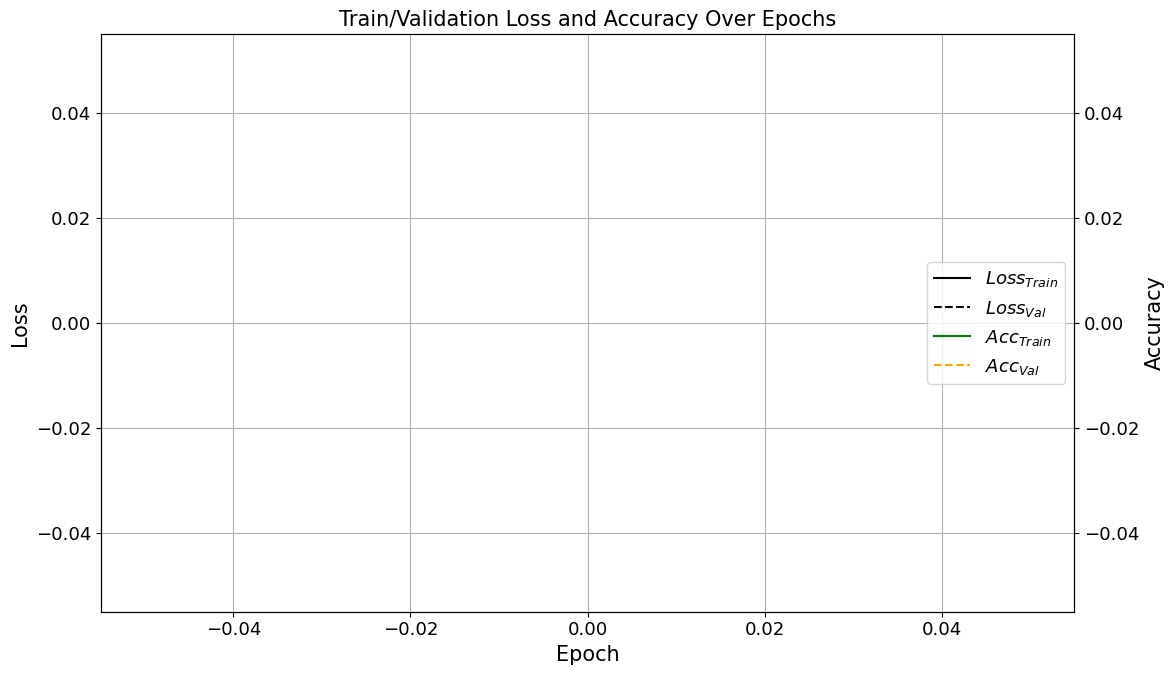

📉 Loss plot saved as:
  - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/train_loss_and_accuracy_per_epoch_plot.png
  - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/train_loss_and_accuracy_per_epoch_plot.pdf


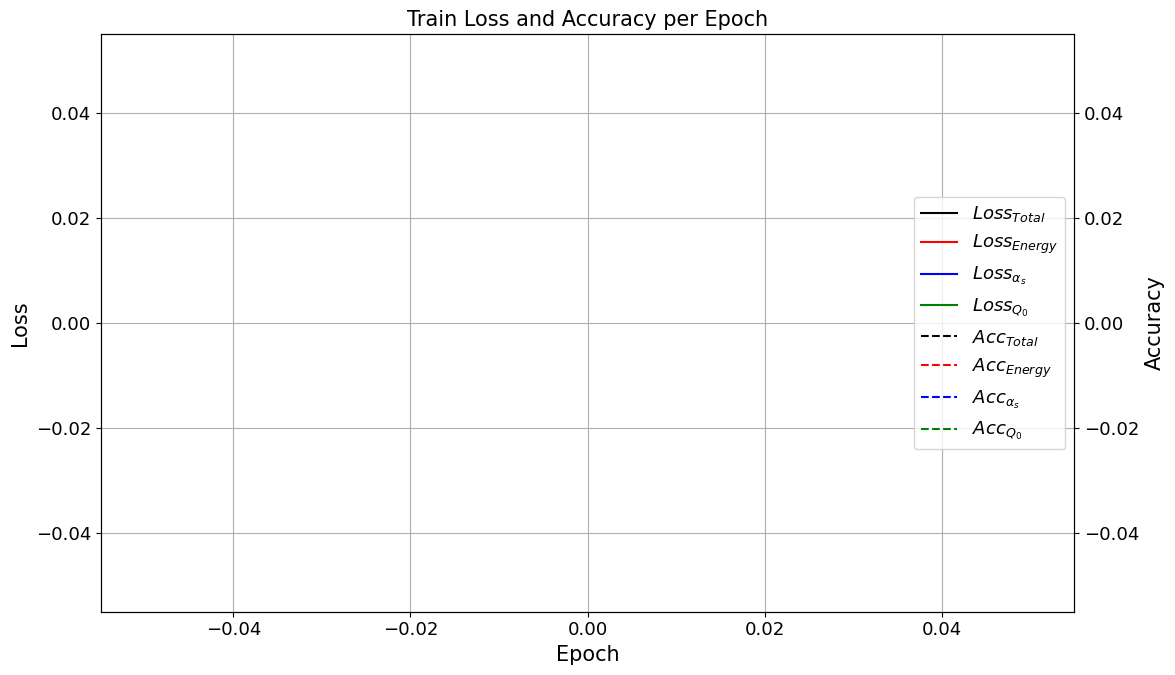

📉 Loss plot saved as:
  - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/validation_loss_and_accuracy_per_epoch_plot.png
  - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/validation_loss_and_accuracy_per_epoch_plot.pdf


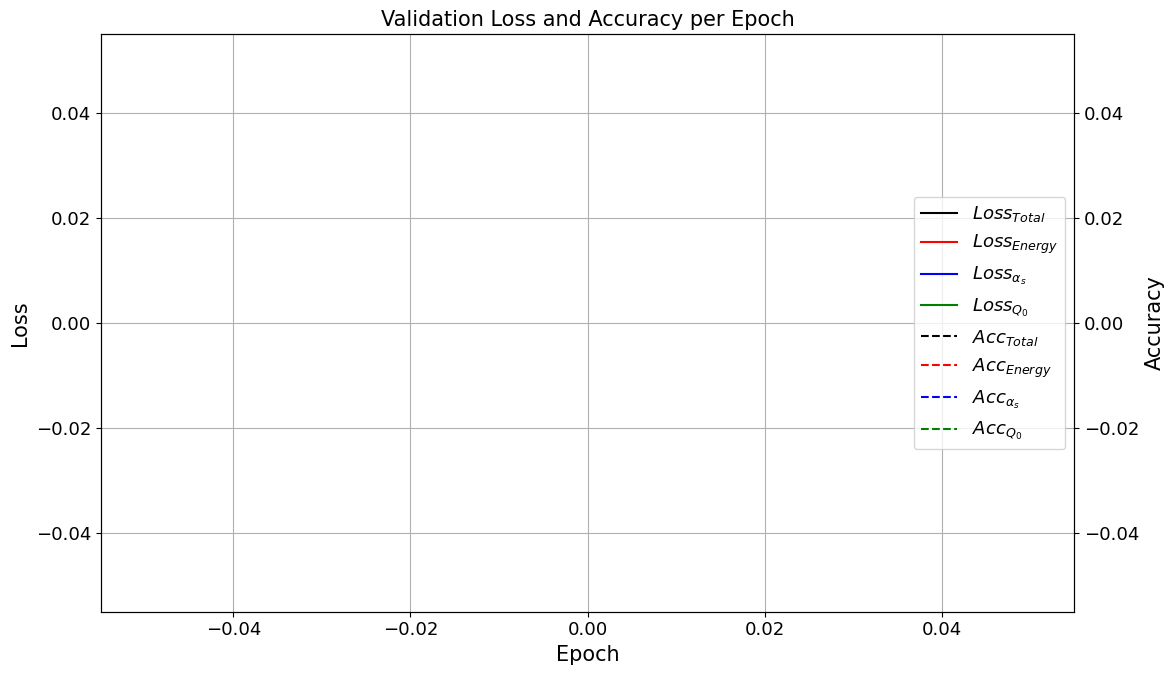

In [17]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")

✅ Saved confusion matrix for energy:
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_energy.png
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_energy.pdf


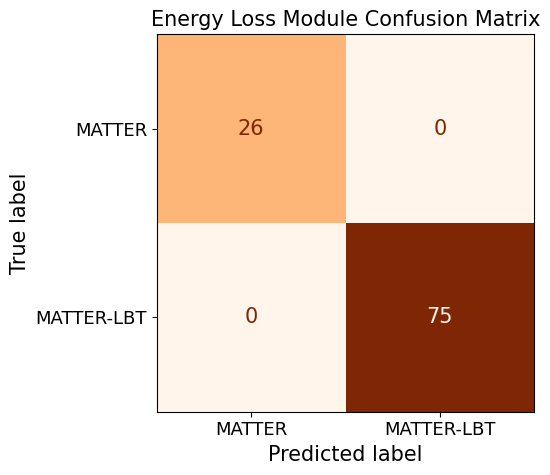

✅ Saved confusion matrix for alpha:
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_alpha.png
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_alpha.pdf


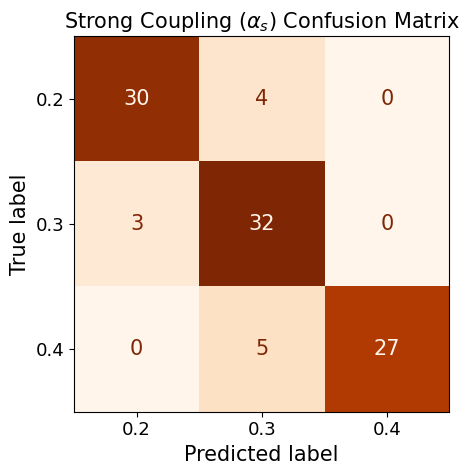

✅ Saved confusion matrix for q0:
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_q0.png
 - experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/confusion_plots/confusion_matrix_q0.pdf


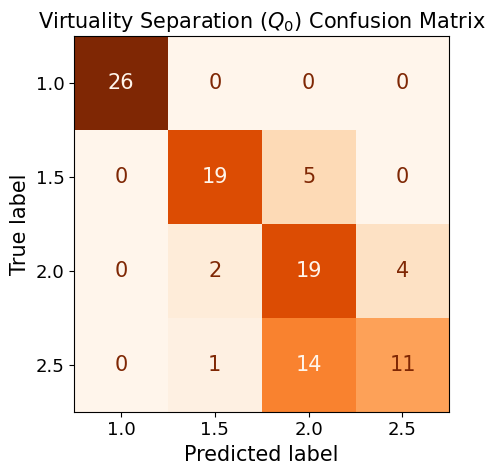

In [18]:
plot_confusion_matrices(best_metrics, output_dir= f"{cfg.output_dir}/val", color_map="Oranges")

In [19]:
alpha_names = ("0.2","0.3","0.4")
q0_names    = ("1.0","1.5","2.0","2.5")


Saved images:
  α_s histogram:         experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/prob_plots/alpha_pred_hist
  α_s avg-prob bars:     experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/prob_plots/alpha_avgprob.png
  α_s probabilities:      experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/val/prob_plots/alpha_pred_hist_probs.csv
  α_s heatmap:           experiments/exp

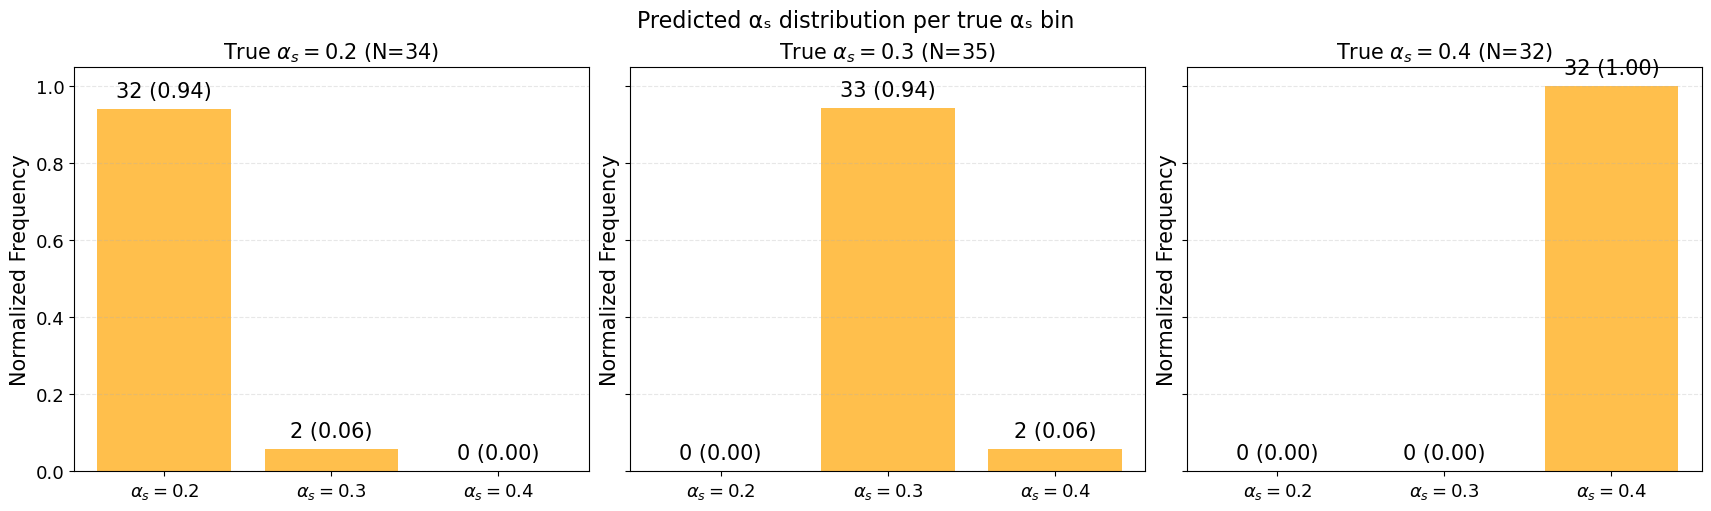

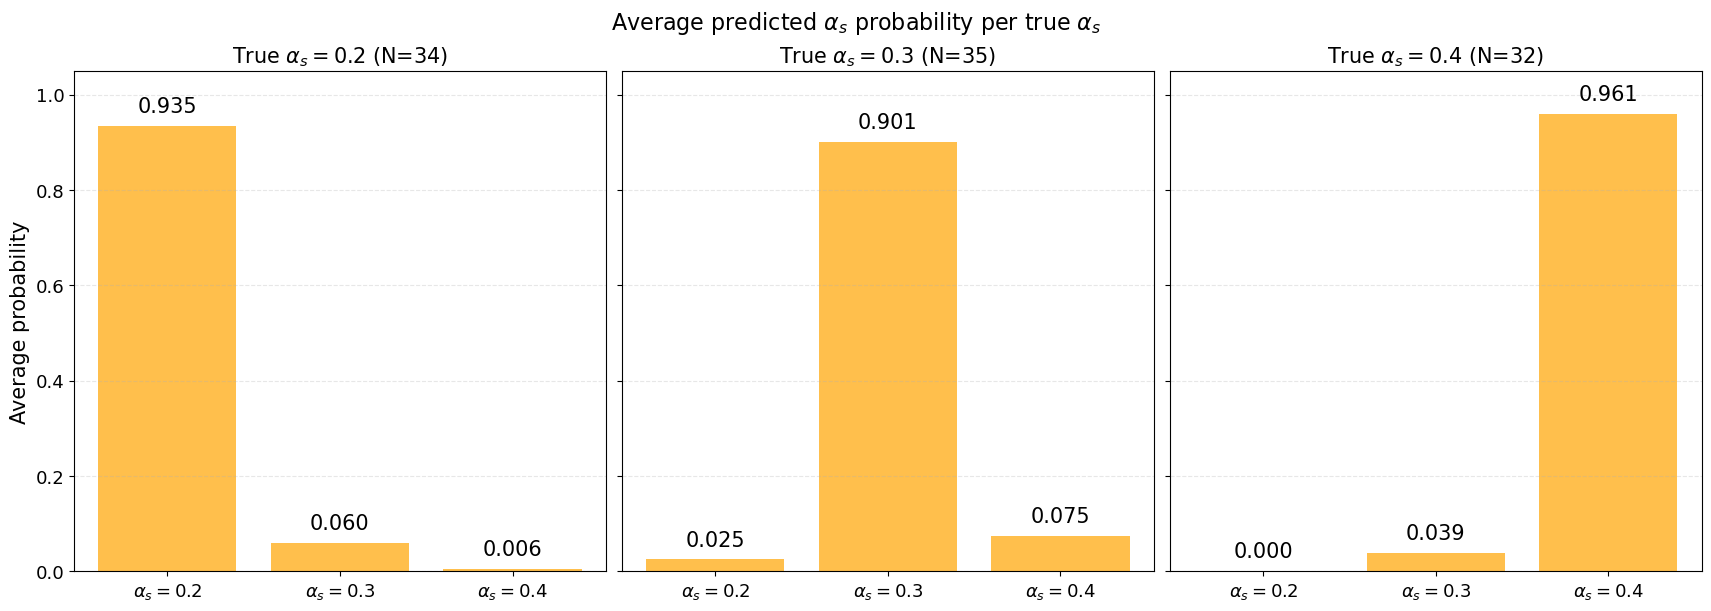

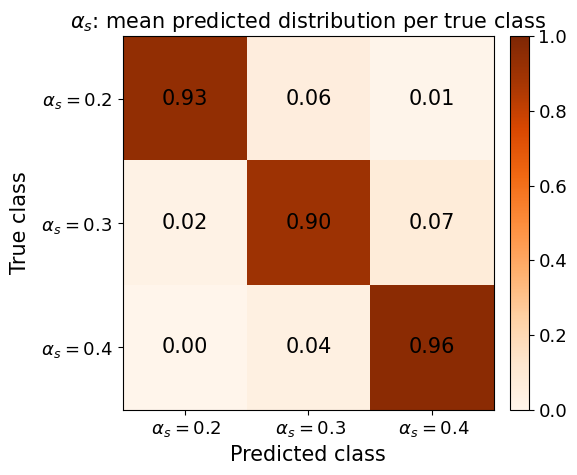

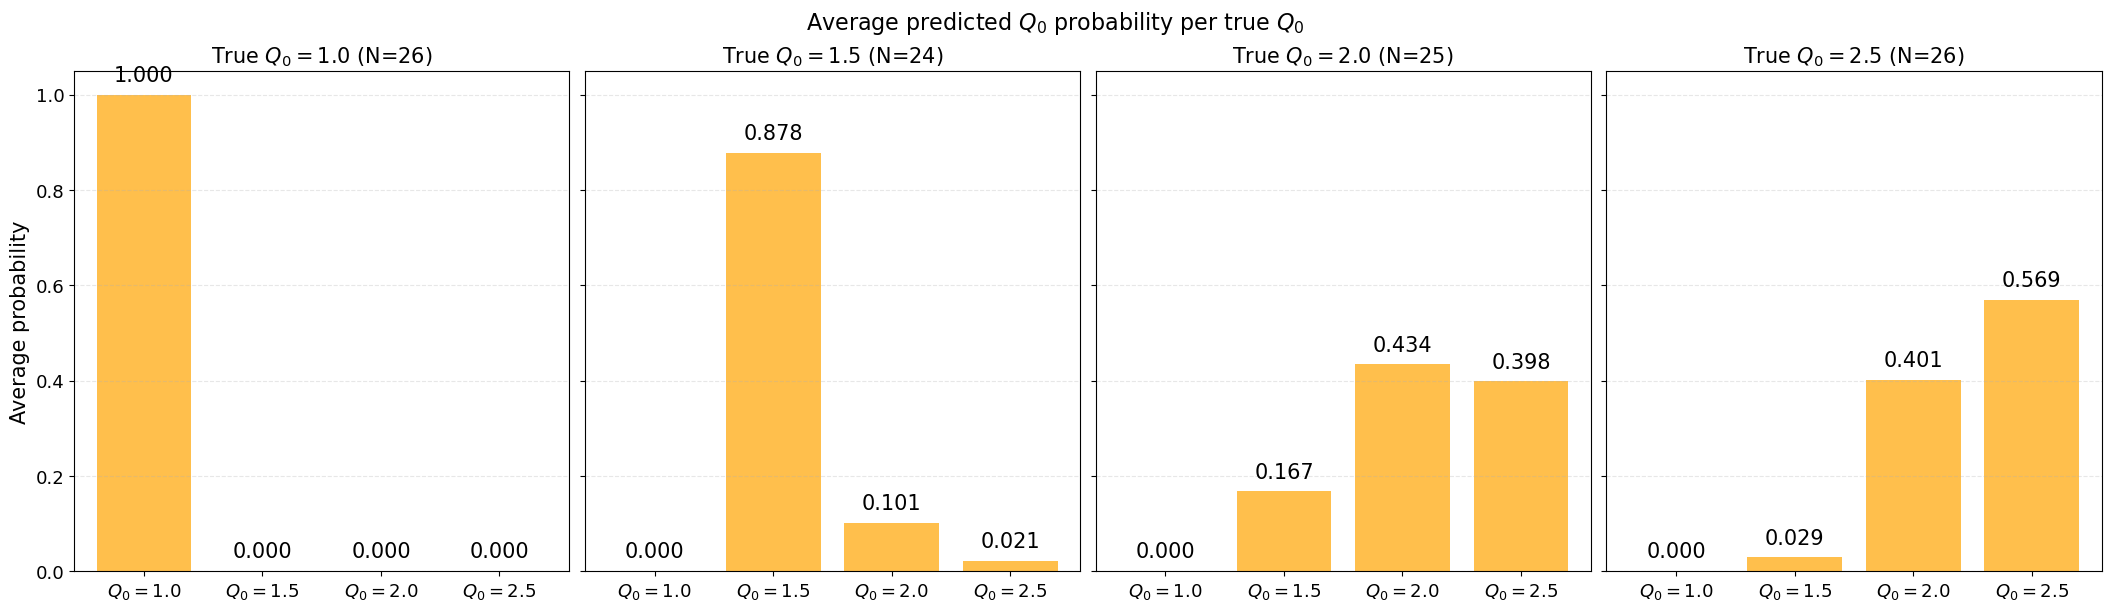

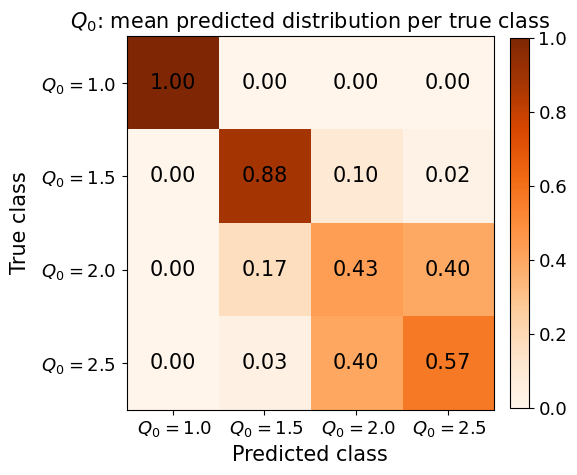

In [20]:
from train_utils.evaluate import evaluate
# experiment folder for artifacts
art_dir = os.path.join(cfg.output_dir,"val/prob_plots")
os.makedirs(art_dir, exist_ok=True)

alpha_hist_path      = os.path.join(art_dir, "alpha_pred_hist")      # .png/.pdf added by evaluate
alpha_avgprob_path   = os.path.join(art_dir, "alpha_avgprob")        # .png/.pdf added by evaluate
q0_avgprob_path      = os.path.join(art_dir, "q0_avgprob")           # .png/.pdf added by evaluate

metrics_val = evaluate(
    val_loader, model, criterion, device,
    loss_weights=getattr(cfg, "loss_weights", None),
    # plots:
    make_alpha_fig=True,
    alpha_fig_path=str(alpha_hist_path),
    make_alpha_avgprob_fig=True,
    alpha_avgprob_fig_path=str(alpha_avgprob_path),
    make_q0_avgprob_fig=True,
    q0_avgprob_fig_path=str(q0_avgprob_path),
    alpha_class_names=alpha_names,
    q0_class_names=q0_names,
)

print("Saved images:")
print("  α_s histogram:        ", metrics_val.get("alpha_hist_path"))
print("  α_s avg-prob bars:    ", metrics_val.get("alpha_avgprob_hist_path"))
print("  α_s probabilities:     ", metrics_val.get("alpha_probs_csv"))
print("  α_s heatmap:          ", metrics_val.get("alpha_heatmap_path"))
print("  Q0  avg-prob bars:    ", metrics_val.get("q0_avgprob_hist_path"))
print("  Q0  probabilities:     ", metrics_val.get("q0_probs_csv"))
print("  Q0  heatmap:          ", metrics_val.get("q0_heatmap_path"))


Saved images:
  α_s histogram:         experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/test/prob_plots/alpha_pred_hist
  α_s avg-prob bars:     experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/test/prob_plots/alpha_avgprob.png
  α_s probabilities:      experiments/exp_adding_loss_weights_for_q0_emphasis/training_output/ViT_tiny_patch16_224_gaussian_lrp_60_rlrp_12_q0_emphasis_bs32_ep2_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded_weighted_lossenergy_loss_output_1.0_alpha_output_1.0_q0_output_3.0/test/prob_plots/alpha_pred_hist_probs.csv
  α_s heatmap:           experiments/

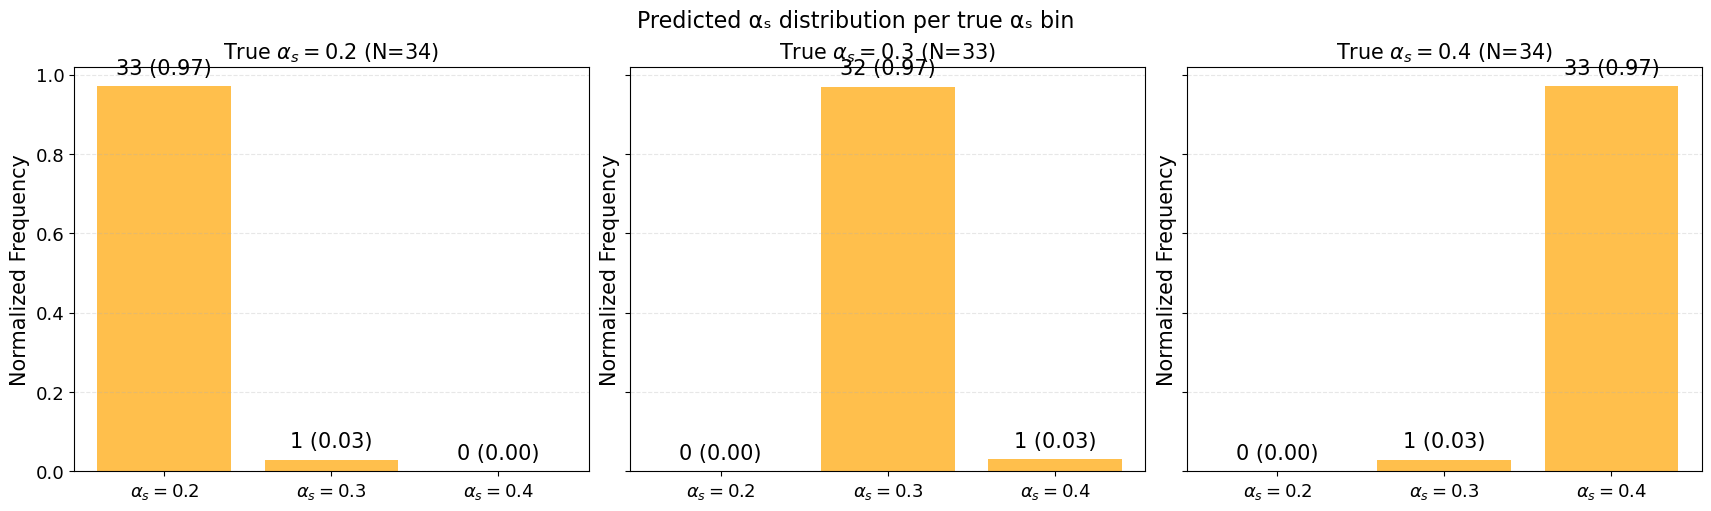

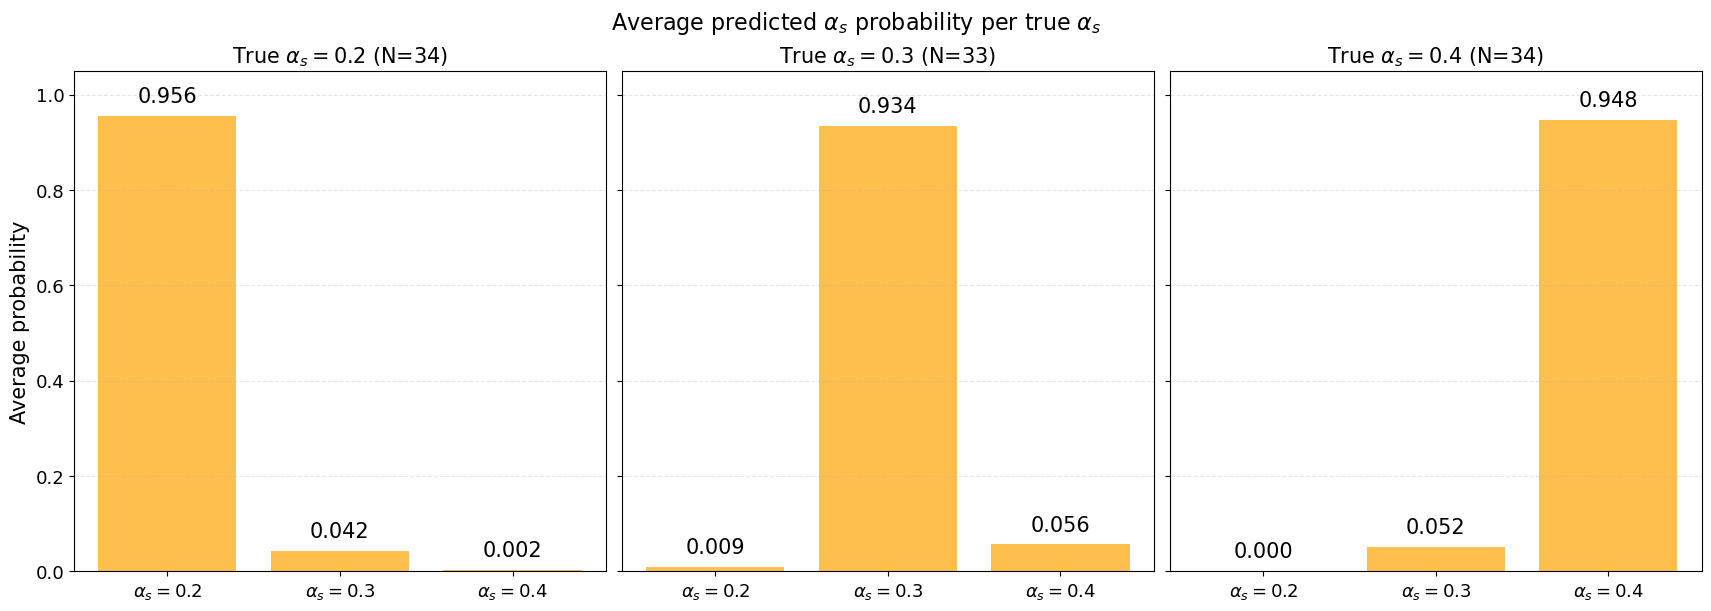

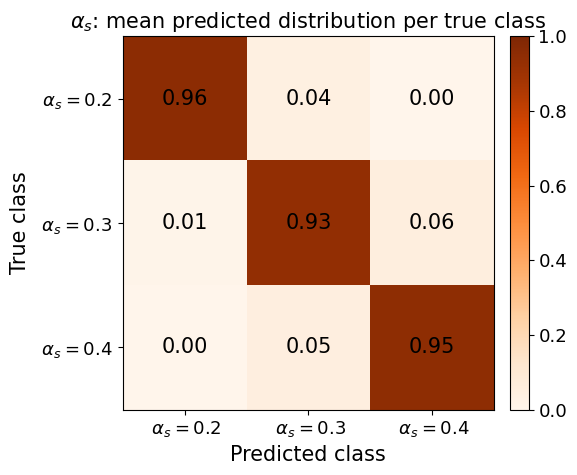

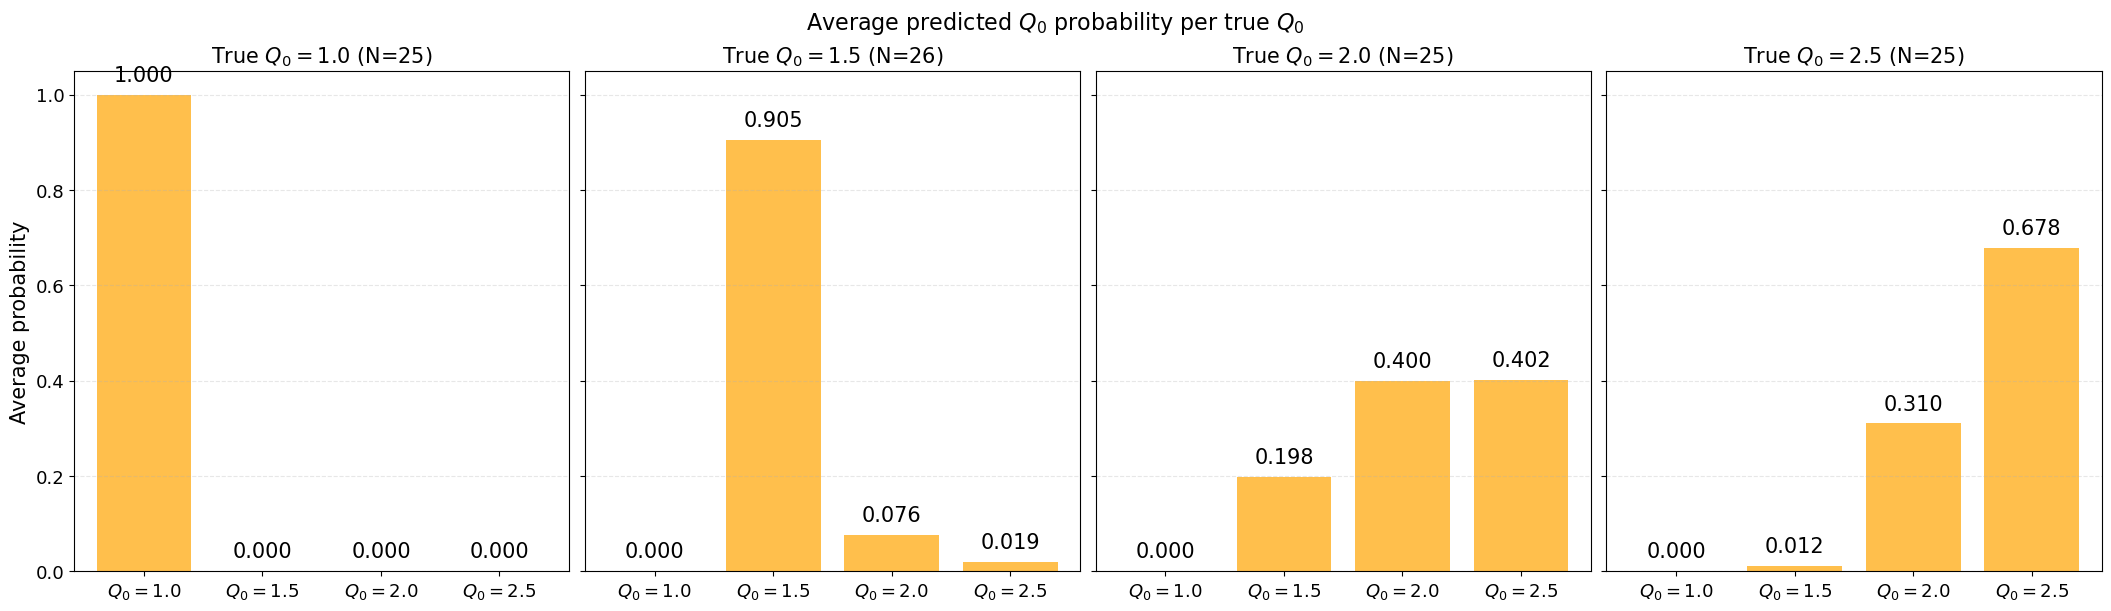

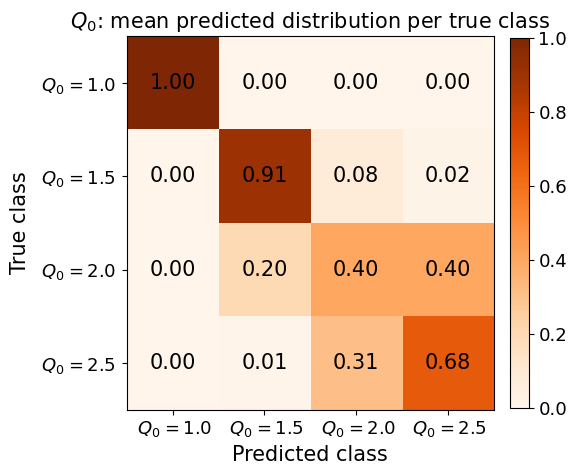

In [21]:
# (optional) test split as well
try:
    from train_utils.evaluate import evaluate
    # experiment folder for artifacts
    art_dir = os.path.join(cfg.output_dir,"test/prob_plots")
    os.makedirs(art_dir, exist_ok=True)

    alpha_hist_path      = os.path.join(art_dir, "alpha_pred_hist")      # .png/.pdf added by evaluate
    alpha_avgprob_path   = os.path.join(art_dir, "alpha_avgprob")        # .png/.pdf added by evaluate
    q0_avgprob_path      = os.path.join(art_dir, "q0_avgprob")           # .png/.pdf added by evaluate

    metrics_test = evaluate(
        test_loader, model, criterion, device,
        loss_weights=getattr(cfg, "loss_weights", None),
        # plots:
        make_alpha_fig=True,
        alpha_fig_path=str(alpha_hist_path),
        make_alpha_avgprob_fig=True,
        alpha_avgprob_fig_path=str(alpha_avgprob_path),
        make_q0_avgprob_fig=True,
        q0_avgprob_fig_path=str(q0_avgprob_path),
        alpha_class_names=alpha_names,
        q0_class_names=q0_names,
    )

    print("Saved images:")
    print("  α_s histogram:        ", metrics_test.get("alpha_hist_path"))
    print("  α_s avg-prob bars:    ", metrics_test.get("alpha_avgprob_hist_path"))
    print("  α_s probabilities:     ", metrics_test.get("alpha_probs_csv"))
    print("  α_s heatmap:          ", metrics_test.get("alpha_heatmap_path"))
    print("  Q0  avg-prob bars:    ", metrics_test.get("q0_avgprob_hist_path"))
    print("  Q0  probabilities:     ", metrics_test.get("q0_probs_csv"))
    print("  Q0  heatmap:          ", metrics_test.get("q0_heatmap_path"))
    have_test = True
except NameError:
    have_test = False